# Visualizing Monero: a figure is worth a thousand words
## [Isthmus](https://www.github.com/mitchellpkt) and [Neptune](https://www.github.com/neptuneresearch)

### >> [Video](https://www.youtube.com/watch?v=XIrqyxU3k5Q) <<

ABSTRACT: Monero’s approach to privacy relies heavily on ensuring that all transactions are indistinguishable, since any patterns visible to an outside observer can be leveraged for blockchain analysis and transaction linking. Mapping the blockchain history to human-interpretable visualizations is a powerful tool for privacy coin research, since potential heuristics that would be challenging to identify from log files are intuitive to spot as visual patterns or clusters corresponding to information leaks. Consensus-level prevention of identifying features (e.g. custom ring sizes - fixed in v8) is paramount, due to the inherent threat of retroactive deanonymization, statistically-noisy change output traces, and combinable heuristics. I’ll introduce the basics of transaction tree analysis and key tools from the exploratory data analysis toolkit (histograms, heatmaps, and more). Together, we’ll leverage these visualizations to intuit ongoing information leaks and mitigation strategies for the next upgrade.


## Import libraries

In [1]:
import numpy as np # math
import pandas as pd # handle data
import json # process API results
import requests # process API results
import matplotlib.mlab as mlab # make figures
import matplotlib.pyplot as plt # make figures
from matplotlib.colors import LogNorm # log color scale

## Personal preferences:

Reasonably-sized plot text

In [2]:
plt.rcParams.update({'font.size': 16})
default_figsize = (16,9)

Prevent scrolling

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Define functions

### Plots

In [4]:
def DoubleHistogram(x, LinBins = 60, LogBins = 60, title = '', xlabel = '', ylabel = '', yscale = 'linear', xscale = 'linear', onlyplot='', vlines=(), doublex = '', figsize=(10,5)):
    # import numpy as np
    # import numpy as np
    # import matplotlib.pyplot as plt
    # MPKT 2019.06
    
    # Linear
    if not onlyplot == 'log':
        fig = plt.figure(figsize=figsize, facecolor='white')
        n, bins, patches = plt.hist(list(x), bins = LinBins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        if vlines:
            if isinstance(vlines, int):
                plt.axvline(x=vlines, color='red')
            else:
                for y in vlines:
                    plt.axvline(x=y, color='red')
                    
        if doublex == 'days':  
            ax1=plt.gca()
            ax2 = ax1.twiny()
            ax1Xs = ax1.get_xticks()

            ax2Xs = []
            for X in ax1Xs:
                ax2Xs.append(int(round(X / 720)))

            ax2.set_xticks(ax1Xs)
            ax2.set_xbound(ax1.get_xbound())
            ax2.set_xticklabels(ax2Xs)
            ax2.set_xlabel("age (days)")
        
        plt.show()


    # Log plot
    if not onlyplot == 'linear':
        fig = plt.figure(figsize=figsize, facecolor='white')
        if type(LogBins) == int:
            LogBins = np.logspace(np.log10(1),np.log10(int(np.max(x))), LogBins)
        n, bins, patches = plt.hist(list(x),bins = LogBins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        if vlines:
            if isinstance(vlines, int):
                plt.axvline(x=vlines, color='red')
            else:
                for y in vlines:
                    plt.axvline(x=y, color='red')
                    
        if doublex == 'days':  
            ax1=plt.gca()
            ax2 = ax1.twiny()
            ax1Xs = ax1.get_xticks()

            ax2Xs = []
            for X in ax1Xs:
                ax2Xs.append(int(round(X / 720)))

            ax2.set_xticks(ax1Xs)
            ax2.set_xbound(ax1.get_xbound())
            ax2.set_xticklabels(ax2Xs)
            ax2.set_xlabel("age (days)")
            
        plt.show()

In [5]:
def Heatmap(x, y, LinBins = (60,60), LogBins = (60,60), title = '', xlabel = '', ylabel = '', yscale = 'linear', xscale = 'linear', onlyplot = '', vmax = 'auto', vmin = 0, clabel=''):
    # import numpy as np
    # import matplotlib.pyplot as plt
    # MPKT 2019.06

    # Log plot
    if not onlyplot == 'linear':
        fig = plt.figure(figsize=(15,5), facecolor='white')
        if len(LogBins) == 2:
            yedges = np.logspace(np.log10(1),np.log10(int(np.max(x))), LogBins[1])
        H, xedges, yedges = np.histogram2d(list(x),list(y), bins=(LogBins[1],yedges))
        
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        
        if vmax == 'auto':
            vmax = np.max(H)
        # Plot 2D histogram using pcolor
        plt.pcolormesh(xedges,yedges,H,vmax=vmax, vmin=vmin)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(clabel)                                          
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.show()
        
        return fig

### API functions

In [6]:
def height_to_hashes(height):
    block = requests.get('https://xmrchain.net/api/block/'+str(height))
    block_json = block.json()
    tx_count = len(block_json['data']['txs'])
    hash_list = list()
    for txc in range(tx_count):
        hash_list.append(block_json['data']['txs'][txc]['tx_hash'])
    return hash_list

In [7]:
def hash_to_rings(hash):
    ring_size = 11 # 2019
    transaction = requests.get('https://xmrchain.net/api/transaction/'+hash)
    transaction_json = transaction.json()
    tx_weight = transaction_json['data']['tx_size']
    rings = transaction_json['data']['inputs']
    ring_dict = dict()
    
    
    for r in range(len(rings)):
        key_image = transaction_json['data']['inputs'][r]['key_image']
        
        block_heights = list()
        for k in range(ring_size):
            block_heights.append(transaction_json['data']['inputs'][r]['mixins'][k]['block_no'])
    
        ring_dict[key_image] = (block_heights);
    
         
        
    return ring_dict, tx_weight

In [8]:
def height_to_rings(height):
    hash_list =  height_to_hashes(height)
    ring_dict = dict()
    return_hash_list = list()
    fee_list = list()

    
    # Import the coinbase
    transaction = requests.get('https://xmrchain.net/api/transaction/'+hash_list[0])
    transaction_json = transaction.json()
    #print(transaction_json)
    total_reward = transaction_json['data']['outputs'][0]['amount'] 
    
    # Import the other transactions
    for h in range(1,len(hash_list)):
        these_rings, tx_weight = hash_to_rings(hash_list[h])
        ring_dict.update(these_rings)
        for j in range(len(these_rings)):
            return_hash_list.append(hash_list[h])
            fee_list.append(tx_weight)
            
    print(return_hash_list)
        
    return ring_dict, return_hash_list, total_reward, fee_list

In [9]:
def stats_for_height(height):
    df = pd.DataFrame(columns=['key_image', 'block_height', 'youngest', 'median', 'tx_hash'])
    ring_dict, return_hash_list, total_reward, fee_list = height_to_rings(height)
    count = 0
    for key, value in ring_dict.items():
        height_list = [int(height) - v for v in value]
        df = df.append({"key_image":key,
                        "block_height":int(height), 
                        "ring_members":value,
                        "youngest":np.min(height_list),
                        "median":int(np.median(height_list)),
                        "tx_hash":return_hash_list[count]}, ignore_index=True)
        count = count + 1

        
    return df, total_reward

### Analysis functions 

In [10]:
def frame_stats(data_frame, height_varname = 'block_height'):
    print('Contains ' + str(len(data_frame)) + ' samples')
    min_height = min(data_frame[height_varname])
    max_height = max(data_frame[height_varname])
    print('From ' + str(min_height) + ' to ' + str(max_height))
    print('(' + str(len(set(data_frame[height_varname]))) + ' blocks)')

In [11]:
def decoy_selection_validation(ring_member_ages_days, age_threshold_days):
    min_age = min(ring_member_ages_days)
    ring_member_ages_shifted = [x - min_age for x in ring_member_ages_days]
    med_rel_age = np.median(ring_member_ages_shifted) # This allows delayed broadcast :- )
    
    print('Raw ring member ages:')
    print(ring_member_ages_days)
    print('\nOffset removed: (to allow delayed broadcast)')
    print(ring_member_ages_shifted)
    print('\nMedian relative age')
    print(med_rel_age)
    
    if med_rel_age <= age_threshold_days:
        print('\nTransaction may have used the correct decoy selection algorithm')
        valid_txn = 1
    
    if med_rel_age > age_threshold_days:
        print('\n'+50*'#'+'\nThis transaction was NOT generated with the correct decoy selection algorithm')
        valid_txn = 0
        
    return valid_txn

# Act I: Transaction fees

## Import data

In [12]:
try:
    tx_fee_df = pd.read_csv('./bigdata/tx_fee_size_ringct_list_export.csv', names=('height','tx_hash_hex','tx_fee_abs','weight'),skiprows=[0])
except:
    print('*** NEED FEE DATA FILE ***')
tx_fee_df.head()

,height,tx_hash_hex,tx_fee_abs,weight
0,1220517,d0499e22757bf94692958f29e1e2f8f328ce366618c680...,26000000000,13062
1,1220517,027e42a0337a4902ff888bcfc334a81964403e29226db6...,26000000000,13062
2,1220517,6f6f2eea2e549a69ad10246511ccc720193f1d41c9fa2c...,26000000000,13264
3,1220517,316bac1402e03f03418bcaea890e8af457138fd1761a75...,26000000000,13061
4,1220517,c22dddbc73076825b163f048122f759cfd983fff9a4bca...,26000000000,13096


## Feature engineering

In [13]:
tx_fee_df['fee_um'] = tx_fee_df['tx_fee_abs']*10**-6
tx_fee_df['weight_kB'] = tx_fee_df['weight']*10**-3
tx_fee_df['fee_um_per_kB'] = tx_fee_df['fee_um']/tx_fee_df['weight_kB']
tx_fee_df = tx_fee_df.drop(columns=['tx_fee_abs', 'weight'])
tx_fee_df.tail()

,height,tx_hash_hex,fee_um,weight_kB,fee_um_per_kB
3722083,1849199,d8309f2b3f3314d43090218abee18368522f99ea86d8f5...,84.88,3.017,28.133908
3722084,1849199,b7434527f2868bd32834db1db8c5ebd99619ea6291f64b...,32.12,1.771,18.136646
3722085,1849199,c4153cc8d5ee1081290ddae1aa6a585b0f94ebd87737ab...,47.29,2.608,18.132669
3722086,1849199,62597960c704bcf7e46d263b4c285710d3f9457cc30145...,32.15,1.773,18.133108
3722087,1849199,728d1ae20340b8f9b51867c3f8906e8f82326af094c076...,236.17,2.605,90.660269


Take a quick peek at the statistics. Note `min` value for `fee_um`

In [14]:
tx_fee_df.describe()

,height,fee_um,weight_kB,fee_um_per_kB
count,3.722088e+06,3.722088e+06,3.722088e+06,3.722088e+06
mean,1.569056e+06,1.368321e+04,1.389230e+01,8.643854e+02
std,1.755888e+05,3.580115e+04,2.213715e+01,2.211121e+03
min,1.220517e+06,0.000000e+00,1.619000e+00,0.000000e+00
25%,1.434964e+06,2.261200e+02,2.718000e+00,9.180622e+01
50%,1.563718e+06,9.056840e+03,1.318900e+01,5.876491e+02
75%,1.720392e+06,1.455012e+04,1.353700e+01,1.041685e+03
max,1.849199e+06,1.126952e+07,3.731660e+02,2.804373e+05


### Transactions without fees??

Was there actually a transaction with 0 fees??

In [15]:
tx_fee_df['tx_hash_hex']['fee_um'==0]

'd0499e22757bf94692958f29e1e2f8f328ce366618c68043fe76408dcab8c52a'

Interesting - a miner included a 0-fee transaction, probably their own. [View on xmrchain](https://xmrchain.net/search?value=d0499e22757bf94692958f29e1e2f8f328ce366618c68043fe76408dcab8c52a).

### Fee distribution
First plot is general overview, second uses log-y axis so we can see the long tail. Note there are some VERY high-fee transactions (12 XMR)

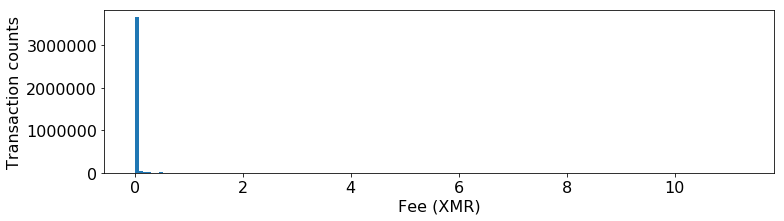

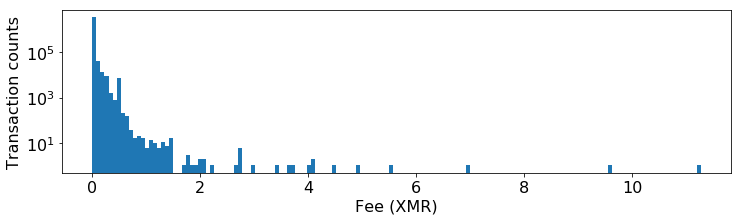

In [16]:
DoubleHistogram(tx_fee_df['fee_um']/10**6, yscale='linear', onlyplot='linear',xlabel='Fee (XMR)', ylabel='Transaction counts',figsize=(12,3),LinBins=150)
DoubleHistogram(tx_fee_df['fee_um']/10**6, yscale='log', onlyplot='linear',xlabel='Fee (XMR)', ylabel='Transaction counts',figsize=(12,3),LinBins=150)

## Fee records over time

Contains 3722088 samples
From 1220517 to 1849199
(530460 blocks)
Contains 3722088 samples
From 1220517 to 1849199
(530460 blocks)


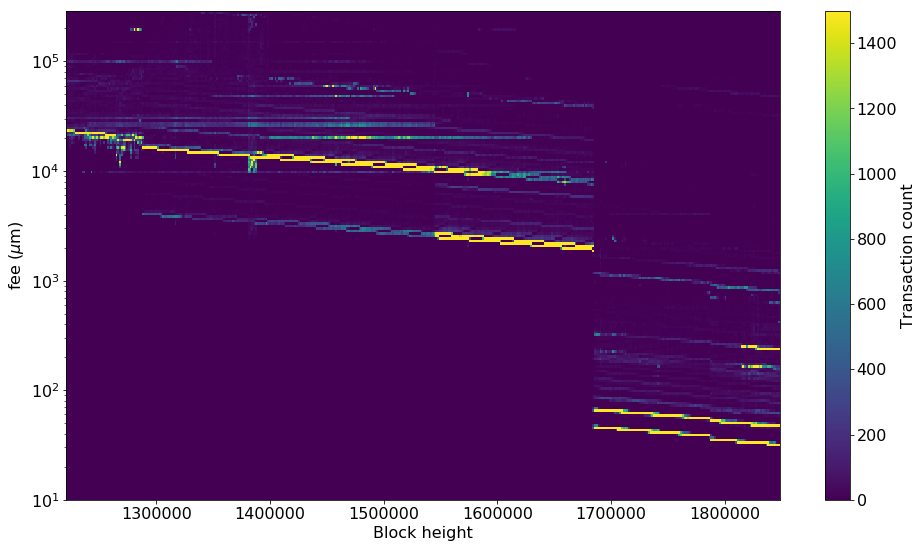

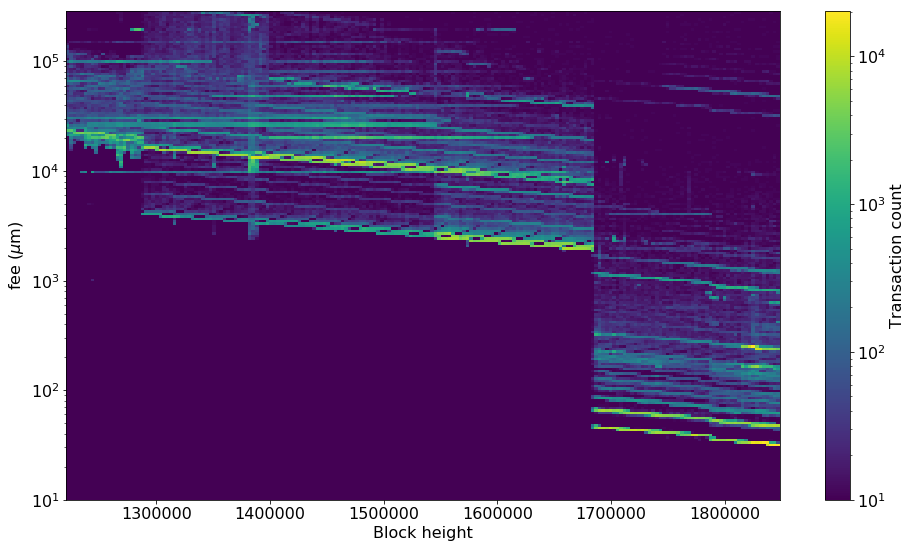

In [17]:
# Estimate the 2D histogram
nbins = (400,200)

# xedges = 
yedges = np.logspace(np.log10(10),np.log10(2.9e+05), nbins[1])

H, xedges, yedges = np.histogram2d(list(tx_fee_df['height']),list(tx_fee_df['fee_um']), bins=(nbins[0],yedges))
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# H = np.log(H)

fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H, vmin=0, vmax=1500)
plt.xlabel('Block height')
plt.ylabel('fee ($\mu$m)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')

# Estimate the 2D with log color 
nbins = (200,200)

# xedges = 
yedges = np.logspace(np.log10(10),np.log10(2.9e+05), nbins[1])

H, xedges, yedges = np.histogram2d(list(tx_fee_df['height']),list(tx_fee_df['fee_um']), bins=(nbins[0],yedges))
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# H = np.log(H)
H = H + 10

fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')

# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, vmin=0, vmax=3000)
plt.yscale('log')
im = ax.pcolormesh(xedges, yedges, H, norm=LogNorm())
plt.set_cmap('viridis')
ax=plt.gca() #get the current axes
PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
cbar = plt.colorbar(PCM) 
#cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')
plt.xlabel('Block height')
plt.ylabel('fee ($\mu$m)')
frame_stats(tx_fee_df, 'height')
frame_stats(data_frame = tx_fee_df, height_varname = 'height')

### What are the most common fees?
(hint: there should not be 'common' fees, this is a bad thing)

In [18]:
pd.value_counts(tx_fee_df['fee_um'].values, sort=True).head(20)

20000.00     105559
26000.00      59878
10000.00      50497
28000.00      48804
30000.00      37759
50000.00      34440
100000.00     15290
60000.00       8119
32000.00       7007
200000.00      6963
40000.00       4439
150000.00      2772
38000.00       2198
34000.00       2062
80000.00       1967
4000.00        1782
32.82          1643
32.80          1632
32.81          1600
32.76          1597
dtype: int64

Note that somebody was using fees of exactly 2*10^4 um

In [19]:
tx_fee_df.sort_values('fee_um').head(10)
samefee = tx_fee_df[tx_fee_df['fee_um']==2e+04]
#samefee.tail()
print('\n% of transactions that used exactly 2000 um fee')
print(len(samefee)/len(tx_fee_df)*100)
print('\nabs:')
print(str(len(samefee)) + 'transactions')
print('of')
print(str(len(tx_fee_df)) + 'transactions')


% of transactions that used exactly 2000 um fee
2.836015698715345

abs:
105559transactions
of
3722088transactions


## Take a look at relative fees (normalized by weight)

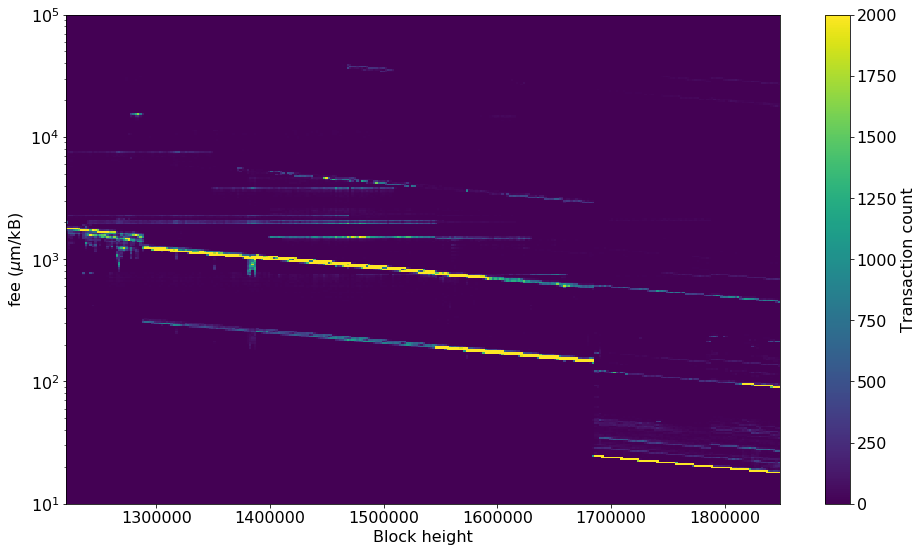

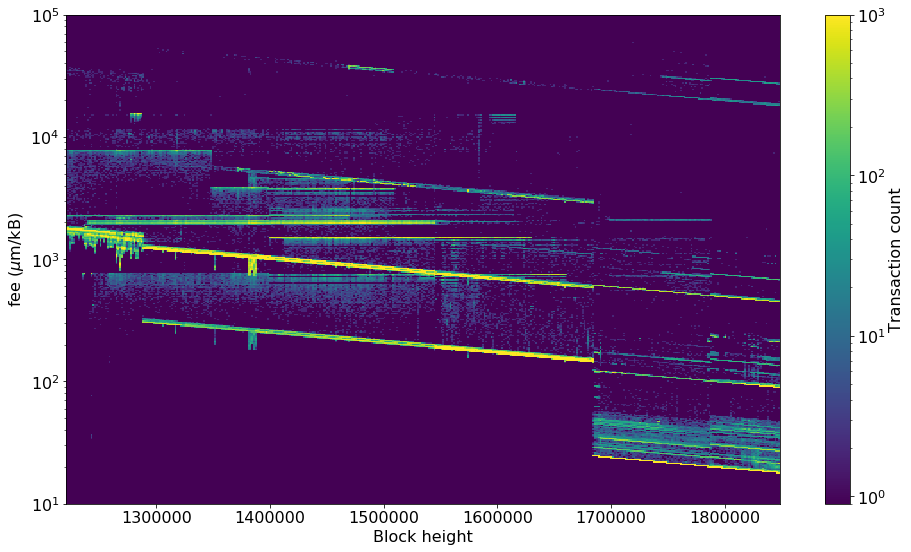

Contains 3722088 samples
From 1220517 to 1849199
(530460 blocks)


In [20]:
# Estimate the 2D histogram
nbins = (300,300)

yedges = np.logspace(np.log10(10),np.log10(10**5), nbins[1])
H, xedges, yedges = np.histogram2d(list(tx_fee_df['height']),list(tx_fee_df['fee_um_per_kB']), bins=(nbins[0],yedges))
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')
# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H,vmax=2000 )
plt.xlabel('Block height')
plt.ylabel('fee ($\mu$m/kB)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')

nbins = (400,400)

yedges = np.logspace(np.log10(10),np.log10(10**5), nbins[1])
H, xedges, yedges = np.histogram2d(list(tx_fee_df['height']),list(tx_fee_df['fee_um_per_kB']), bins=(nbins[0],yedges))
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
H = H + .9
fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')
# Plot 2D histogram using pcolor
plt.yscale('log')
im = ax.pcolormesh(xedges, yedges, H, norm=LogNorm(),vmax=1000)
plt.set_cmap('viridis')
ax=plt.gca() #get the current axes
PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
cbar = plt.colorbar(PCM) 
#cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')
plt.xlabel('Block height')
plt.ylabel('fee ($\mu$m/kB)')
plt.show()

frame_stats(tx_fee_df, height_varname='height')


## Are people using repeats of relative fees too?
(of course)

In [21]:
pd.value_counts(tx_fee_df['fee_um_per_kB'].values, sort=True).head(20)

1530.338970     22332
1527.533797     17680
1985.793936     13562
3828.777089     11679
1531.628121      8825
1989.440661      7685
1996.007984      7457
1991.116557      6533
2315.172094      6512
1530.221882      5988
1527.417138      5737
1531.510835      5696
2291.475710      5023
1512.058668      4962
7736.943907      4562
2065.049045      4275
15473.887814     4148
1514.807241      4134
3868.471954      4128
1511.944360      3903
dtype: int64

## Proposal:
Limit the precision of fees - allowing 10 significant figures (like `1527.533797`) is overkill

One possible solution is a consensus rule that fees must be a power of 2

Here is that filter, applied retrospectively to all RingCT transactions through May 2019

Contains 3722088 samples
From 1220517 to 1849199
(530460 blocks)


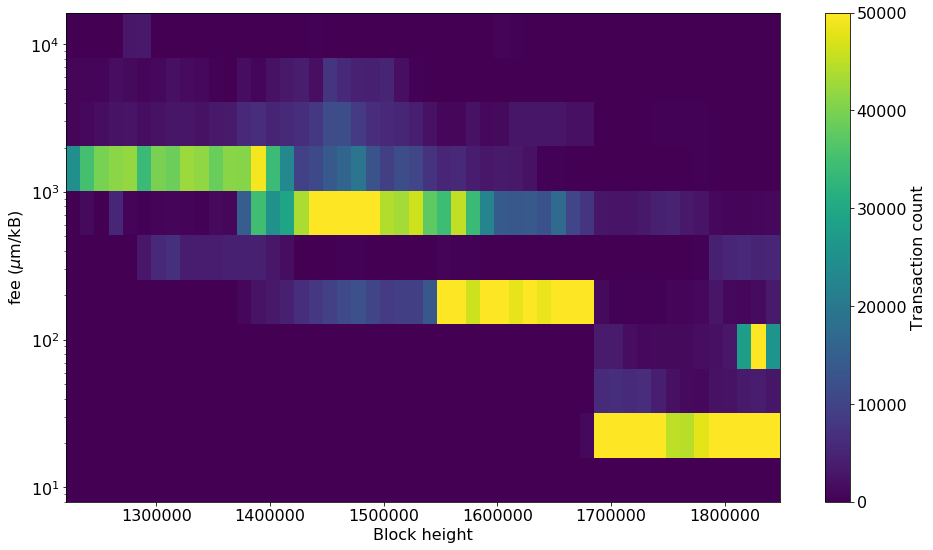

In [22]:
# Estimate the 2D histogram
nbins = (50,100)


yedges = list()
exps = range(3,15)
for expon in exps:
    yedges.append(2**expon)
H, xedges, yedges = np.histogram2d(list(tx_fee_df['height']),list(tx_fee_df['fee_um_per_kB']), bins=(nbins[0],yedges))
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# H = np.log(H)
fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')
# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H, vmax=50000 )
plt.xlabel('Block height')
plt.ylabel('fee ($\mu$m/kB)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')


frame_stats(tx_fee_df, height_varname='height')


## Combined heuristics
Fee fingerprinting can be combined with other heuristics such as timing analysis

In [23]:
window = tx_fee_df[abs(tx_fee_df['height']-1848270)<720*7.5]
window.sort_values(by='fee_um_per_kB', ascending=False).head()

,height,tx_hash_hex,fee_um,weight_kB,fee_um_per_kB
3645668,1843321,47e6ea520be2fa2df1e8470b6fe7154ffdd21635fb3cf4...,49093.51,1.773,27689.514946
3642351,1843062,f74a74f88576d25296c9ac659a55f956a779fbc4934153...,49120.28,1.774,27688.996618
3651318,1843758,c7deb7d8901c5f0df06cc7a6c0226fde57df415a7d184b...,49069.41,1.773,27675.922166
3643065,1843125,f9eb847ee86f58e1e2352a853274d5ab5592353e5c5b06...,49120.28,1.775,27673.397183
3642576,1843087,53d13def576017895f7fb7529ec0a4ccf0cd079c72060b...,49120.28,1.775,27673.397183


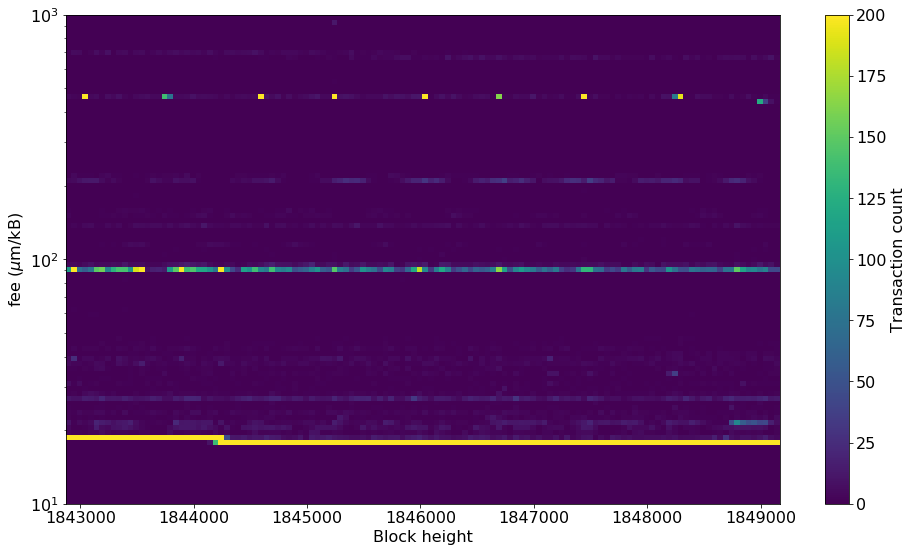

In [24]:
# Estimate the 2D histogram
nbins = (50,100)

# THE ORIGINAL was 1846000
heights = list(window['height'])
yedges = np.logspace(np.log10(10),np.log10(10**3), nbins[1])
xedges = list(range(min(heights), max(heights),nbins[0]))
H, xedges, yedges = np.histogram2d(list(window['height']),list(window['fee_um_per_kB']), bins=(xedges,yedges))
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
#H = np.log(H+10**-12)

fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H,vmax=200)
plt.xlabel('Block height')
plt.ylabel('fee ($\mu$m/kB)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')

import matplotlib.patches as patches

style="Simple,tail_width=2,head_width=15,head_length=8"
kw = dict(arrowstyle=style, color="r")

# 1845985
#a1 = patches.FancyArrowPatch((1845985,0.000465), (1846055,0.000465),connectionstyle="arc3,rad=.2", **kw)
#a2 = patches.FancyArrowPatch((1846055,465), (1847440,465),connectionstyle="arc3,rad=.2", **kw)
#a3 = patches.FancyArrowPatch((1847440,465), (1848275,465),connectionstyle="arc3,rad=.3", **kw)

for a in []:#[a2,a3]:
    plt.gca().add_patch(a)
plt.show()

# Act II: Juvenile ring members

## Pull down live network info

In [25]:
network_info = requests.get('https://xmrchain.net/api/networkinfo')
network_info_data = network_info.json()
current_height = network_info_data['data']['height']
print('Current height: ' + str(current_height))

Current height: 1867903


## Import data

Set parameters

In [26]:
Q_use_aux_file = 1
aux_filename = 'data_v3'
Q_verbose = 1

Use aux file if available

In [27]:
try:
    tx_df = pd.read_pickle('./bigdata/' + aux_filename + '_txns.pkl')
    coinbase_df = pd.read_pickle('./bigdata/' + aux_filename + '_coinbases.pkl')
except:
    print('*** NEED RING MEMBER DATA FILE ***')

### Youngest ring member age
Were there any juvenile spends (< 10 block confirmation)

In [28]:
print(tx_df.youngest.describe())
print('min: ' + str(np.min(tx_df.youngest)) + 'block')
print('max: ' + str(np.max(tx_df.youngest)) + 'block')

count     389413
unique      3134
top           11
freq       17217
Name: youngest, dtype: int64
min: 1block
max: 1060910block


Apparently there were!

Let's take a look - same data visualized on 3 axes:
-  linear x, linear y to give a sense of scale
-  linear x, log y
-  log x, log y

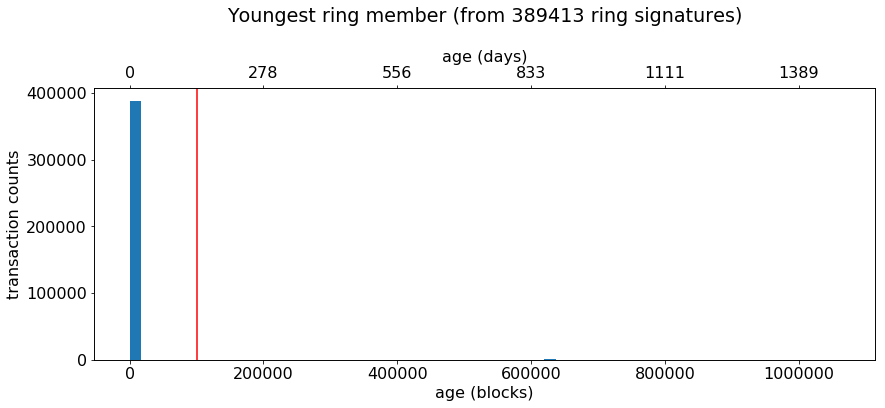

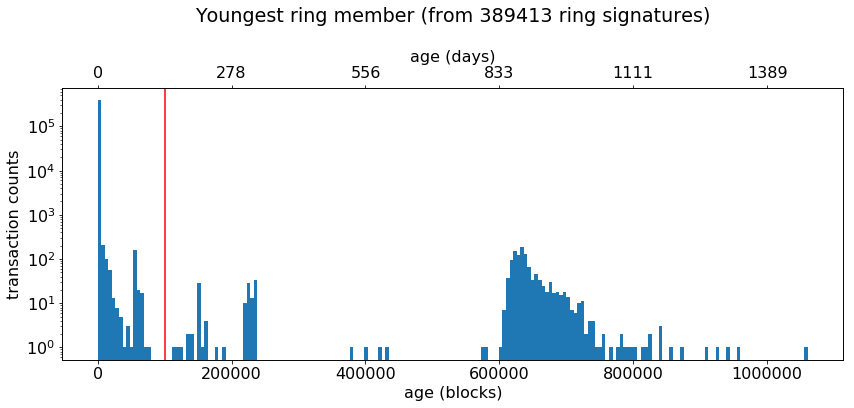

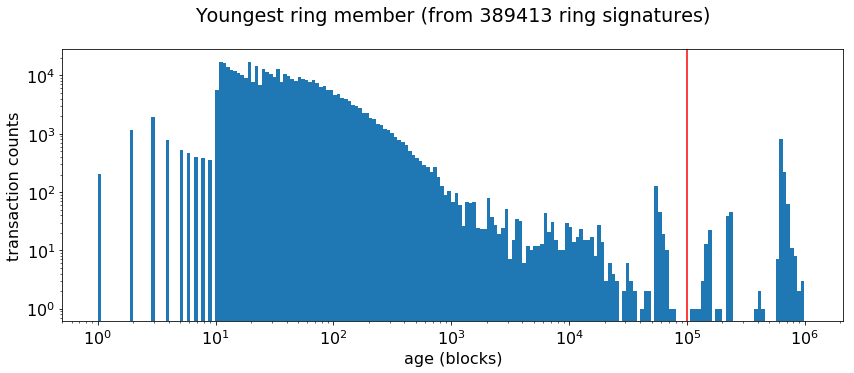

Contains 389413 samples
From 1841850 to 1857853
(14719 blocks)


In [29]:
DoubleHistogram(tx_df['youngest'], title = 'Youngest ring member (from ' + str(len(tx_df)) + ' ring signatures)\n', xlabel = 'age (blocks)', ylabel = 'transaction counts', yscale = 'linear', xscale = 'linear', onlyplot = 'linear', vlines=10**5, doublex='days', figsize=(14,5))
DoubleHistogram(tx_df['youngest'], title = 'Youngest ring member (from ' + str(len(tx_df)) + ' ring signatures)\n', xlabel = 'age (blocks)', ylabel = 'transaction counts', yscale = 'log', xscale = 'linear', onlyplot = 'linear', vlines=10**5, doublex='days', LinBins=200, figsize=(14,5))
DoubleHistogram(tx_df['youngest'], title = 'Youngest ring member (from ' + str(len(tx_df)) + ' ring signatures)\n', xlabel = 'age (blocks)', ylabel = 'transaction counts', yscale = 'log', xscale = 'log', onlyplot = 'log', vlines=10**5, LogBins=200, figsize=(14,5))
frame_stats(tx_df)

### Let's zoom in transactions whose youngest member is < 100 blocks old

0.3% of ring signatures have youngest member older than 10^5 blocks


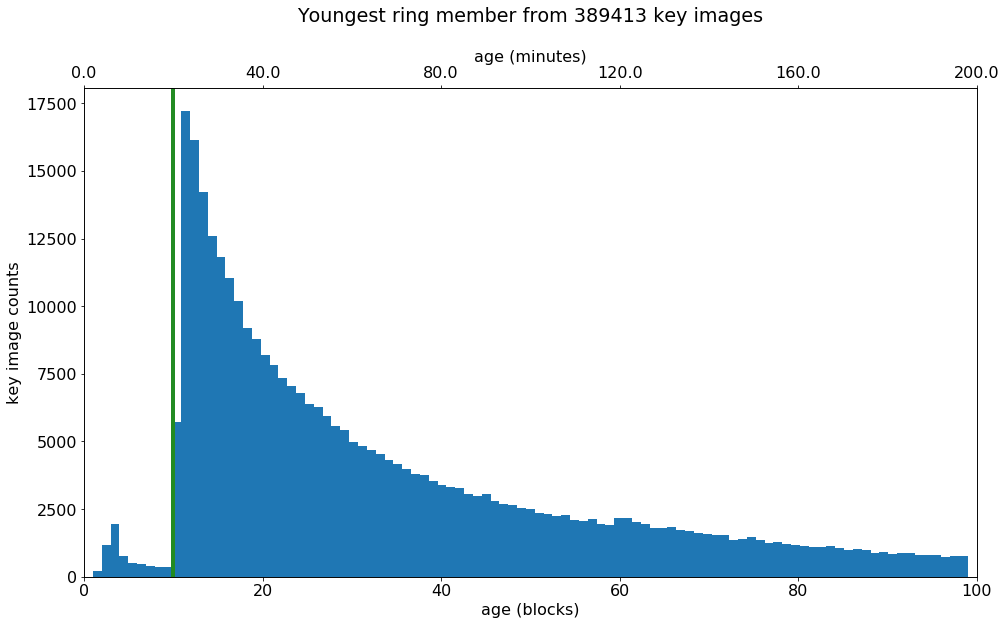

1.6% of ring signatures contain member younger than 10 blocks
389413
1841850
1857853



335923

In [30]:
frac_too_old = len(list(tx_df['youngest'][tx_df['youngest']>10**5]))/len(tx_df)*100
print(str(round(frac_too_old,1)) + '% of ring signatures have youngest member older than 10^5 blocks')

youngest_zoom = 100
fig = plt.figure(figsize=default_figsize, facecolor='white')
n, bins, patches = plt.hist(list(tx_df['youngest'][tx_df['youngest']<youngest_zoom]), bins = 99)
plt.xlabel('age (blocks)')
plt.ylabel('key image counts')
plt.title('Youngest ring member from ' + str(len(tx_df)) + ' key images\n')
# plt.axvline(10, color='lime', linestyle='-', lw=7)
plt.axvline(10, color='forestgreen', linestyle='-', lw=4)
plt.xlim((0,100))

ax1=plt.gca()
ax2 = ax1.twiny()
ax1Xs = ax1.get_xticks()

ax2Xs = []
for X in ax1Xs:
    ax2Xs.append(X * 2)

ax2.set_xticks(ax1Xs)
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(ax2Xs)
ax2.set_xlabel("age (minutes)")
plt.show()

frac_ignore = len(list(tx_df['youngest'][tx_df['youngest']<10]))/len(tx_df)*100
print(str(round(frac_ignore,1)) + '% of ring signatures contain member younger than 10 blocks')
print(len(tx_df))
print(str(min(tx_df['block_height'])))
print(str(max(tx_df['block_height'])))
print()
len(tx_df[tx_df['youngest']<100])

### View over time
Let's see if these juvenile spends were a one-time event, or constant phenomenon
(answer: constant)

Text(0, 0.5, 'Key image count')

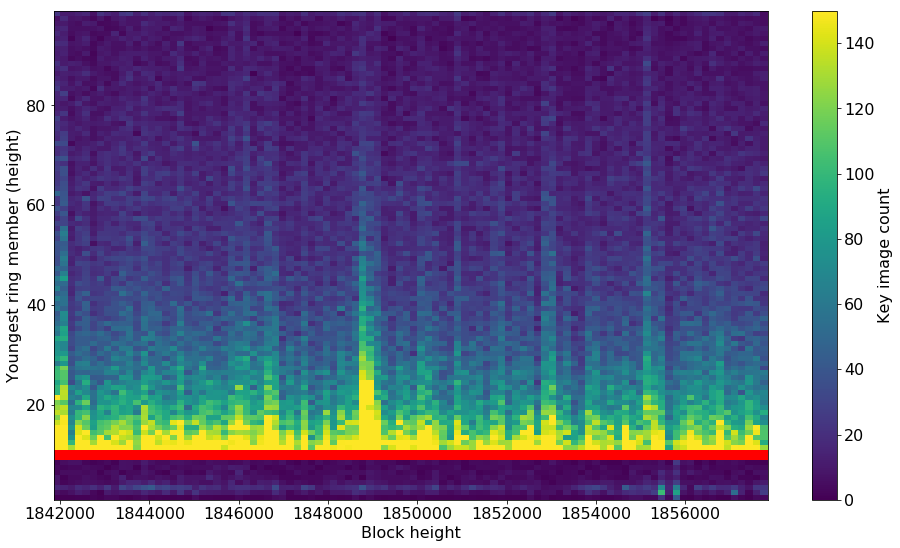

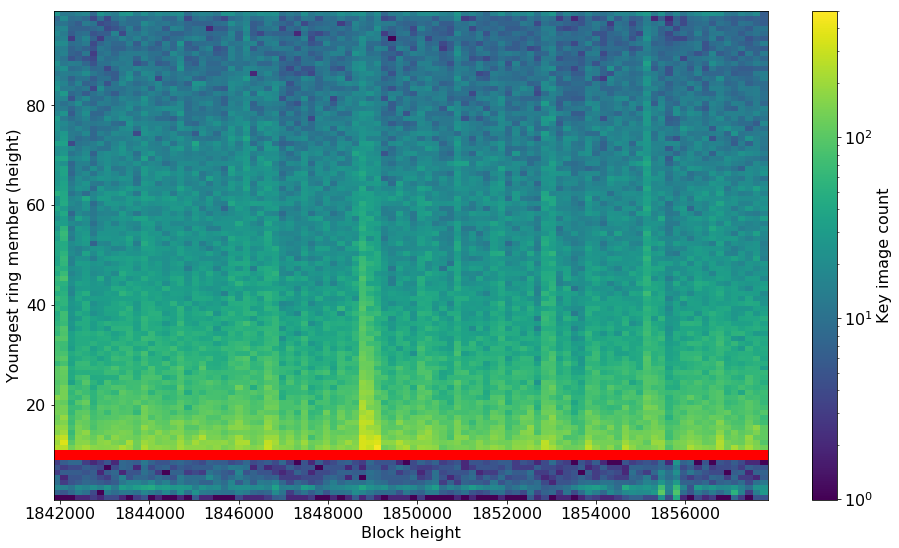

In [31]:
# Estimate the 2D histogram
nbins = (98,98)


H, xedges, yedges = np.histogram2d(list(tx_df['block_height'][tx_df['youngest']<100]),list(tx_df['youngest'][tx_df['youngest']<100]),bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)

fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H, vmax = 150, vmin=0)
plt.xlabel('Block height')
plt.ylabel('Youngest ring member (height)')
cbar = plt.colorbar()
plt.axhline(y=10, color='red', lw=10)
plt.set_cmap('viridis')
cbar.ax.set_ylabel('Key image count')

# Estimate the 2D histogram
nbins = (98,98)


H, xedges, yedges = np.histogram2d(list(tx_df['block_height'][tx_df['youngest']<100]),list(tx_df['youngest'][tx_df['youngest']<100]),bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
H = H + 0.99
fig, ax = plt.subplots(figsize=default_figsize, facecolor='white')

# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, vmax = 200, vmin=0, norm=plt.colors.LogNorm())
im = ax.pcolormesh(xedges, yedges, H, norm=LogNorm(), vmax=500)
plt.xlabel('Block height')
plt.ylabel('Youngest ring member (height)')
plt.axhline(y=10, color='red', lw=10)
plt.set_cmap('viridis')

ax=plt.gca() #get the current axes
PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
cbar = plt.colorbar(PCM) 
#cbar = plt.colorbar()
cbar.ax.set_ylabel('Key image count')



# Act III: Median ring member age
This is actually the offset-corrected median ring member age (to account for delayed broadcast)

As usual, we'll examine the same data on a variety of lin/log axes to get a sense of scale and investigate fine structure

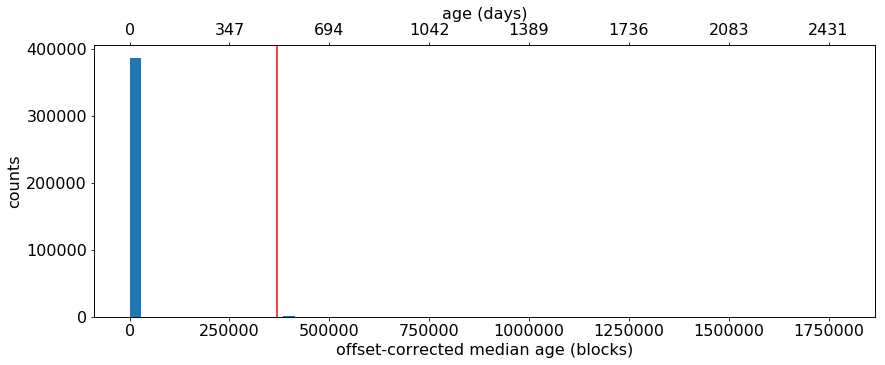

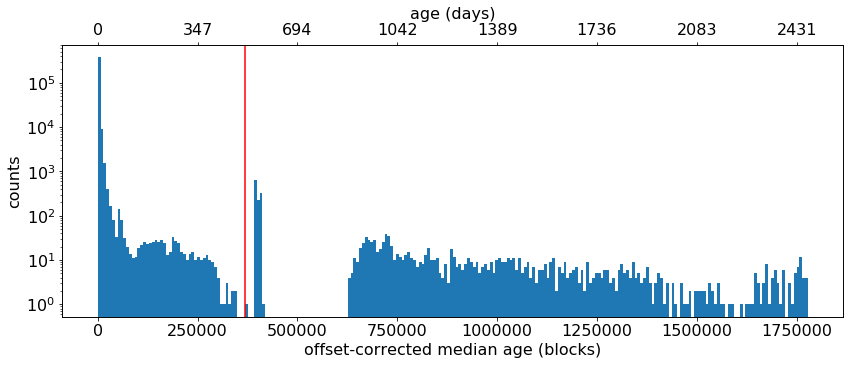

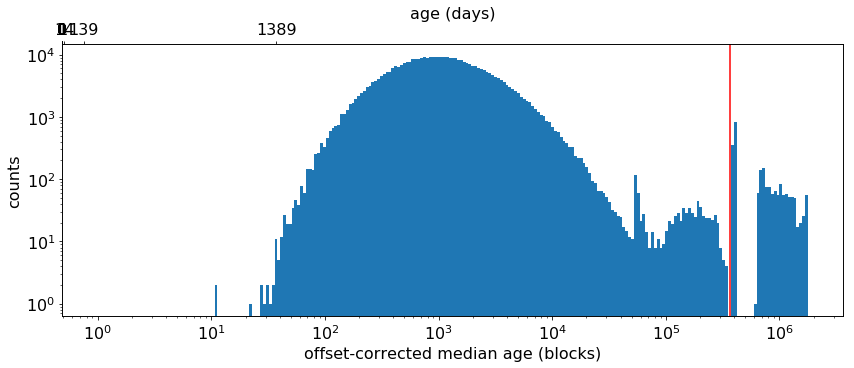

In [32]:
toolong = 37*10**4
DoubleHistogram(tx_df['median'], title = '', xlabel = 'offset-corrected median age (blocks)', ylabel = 'counts', yscale = 'linear', xscale = 'linear', onlyplot = 'linear', vlines = toolong, figsize=(14,5), doublex='days')
DoubleHistogram(tx_df['median'], title = '', xlabel = 'offset-corrected median age (blocks)', ylabel = 'counts', xscale = 'linear', yscale = 'log', onlyplot = 'linear', vlines = toolong, LinBins=250, figsize=(14,5), doublex='days')
DoubleHistogram(tx_df['median'], title = '', xlabel = 'offset-corrected median age (blocks)', yscale = 'log', xscale = 'log', ylabel = 'counts', onlyplot = 'log',vlines = toolong,LogBins=250, figsize=(14,5), doublex='days')

How many of the transactions use an extremely unusual (and information-leaking) decoy selection algorithm?

In [33]:
print('threshold = ' + str(int(toolong)) + ' blocks')
print('threshold = ' + str(round(int(toolong)/720)) + ' days')

print('overage:')
print(len(tx_df['median'][tx_df['median']>toolong]))
print('total blocks:')
print(len(tx_df['median']))
print('ratio:')
print(str(len(tx_df['median'][tx_df['median']>720*30])/len(tx_df['median'])*100)+'%')

threshold = 370000 blocks
threshold = 514 days
overage:
2333
total blocks:
389413
ratio:
0.9814772490902974%


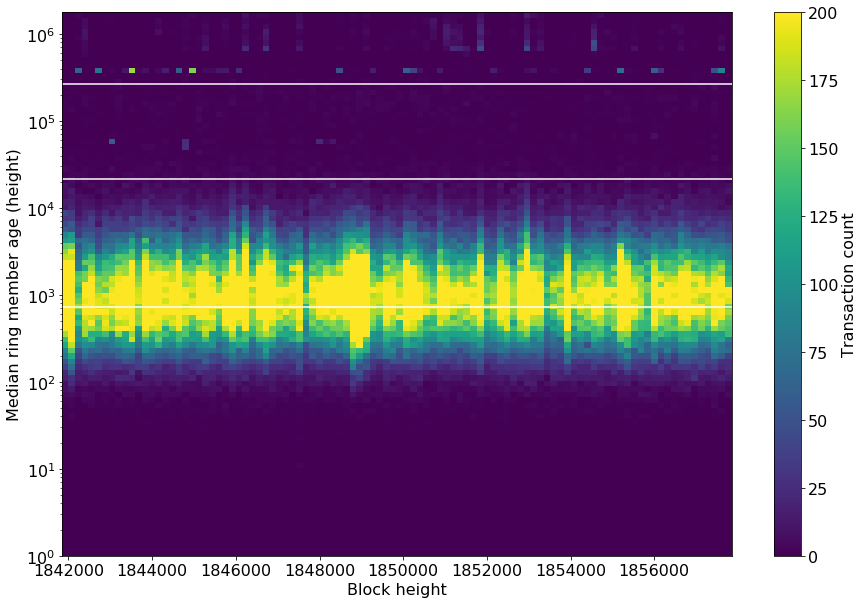

In [34]:
# Estimate the 2D histogram
nbins = (100,100)

# xedges = 
yedges = np.logspace(np.log10(1),np.log10(int(np.max(tx_df['median']))), nbins[1])

H, xedges, yedges = np.histogram2d(list(tx_df['block_height']),list(tx_df['median']), bins=(nbins[0],yedges))
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)

fig, ax = plt.subplots(figsize=(15,10), facecolor='white')

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H,vmax=200, vmin=0)
plt.xlabel('Block height')
plt.ylabel('Median ring member age (height)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Transaction count')
plt.axhline(y=720, color='white')
plt.axhline(y=720*30,color='white')
plt.axhline(y=720*365,color='white')



### Check out the cumulative distribution

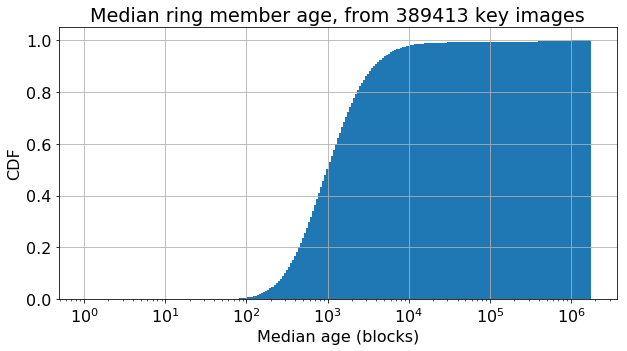

In [35]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')
bin_edges = np.logspace(np.log10(1),np.log10(np.max(tx_df['median'])), 250)

# plot the cumulative histogram
n, bins, patches = ax.hist(list(tx_df['median']), bins=bin_edges, density=1, histtype='stepfilled',cumulative=True)

ax.grid(True)
plt.title('Median ring member age, from ' + str(len(tx_df)) + ' key images')
ax.set_xlabel('Median age (blocks)')
ax.set_ylabel('CDF')
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

## Make background for title slide

Text(842.315625, 0.5, 'Transaction count')

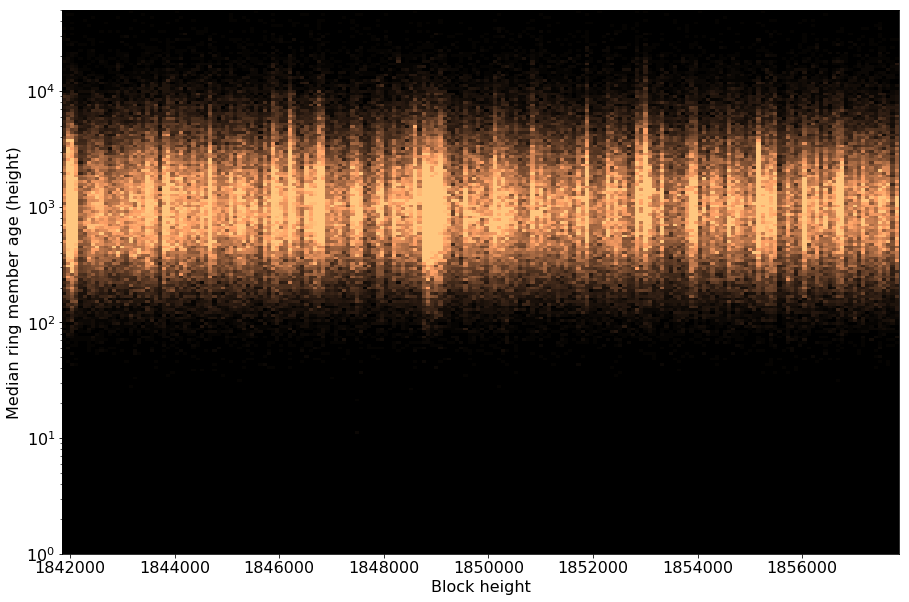

In [36]:
# Estimate the 2D histogram
nbins = (200,200)

# xedges = 
yedges = np.logspace(np.log10(1),np.log10(0.5*10**5), nbins[1])

H, xedges, yedges = np.histogram2d(list(tx_df['block_height']),list(tx_df['median']), bins=(nbins[0],yedges))
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)

fig, ax = plt.subplots(figsize=(15,10), facecolor='white')

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H,vmax=50, vmin=0)
plt.xlabel('Block height')
plt.ylabel('Median ring member age (height)')
plt.yscale('log')
#cbar = plt.colorbar()
plt.set_cmap('copper')

cbar.ax.set_ylabel('Transaction count')



## Bonus analysis:

Apply guess-newest heuristic to uniform txns, to estimate spend distribution

This makes two big assumptions:
-  Transactions with extremely long offset-corrected median age used a uniform decoy selection algorithm
-  For transactions with a uniform decoy selection algorithm, the youngest member is usually the true spend (see Möser et al)

These are both *weak* assumptions, so assume lots of Type I error. A much better (albeit more complex) way to approach this question would be ensemble subtraction of wallet distribution from observed distribution. Below is just a hacky approach that should not be taken too seriously...

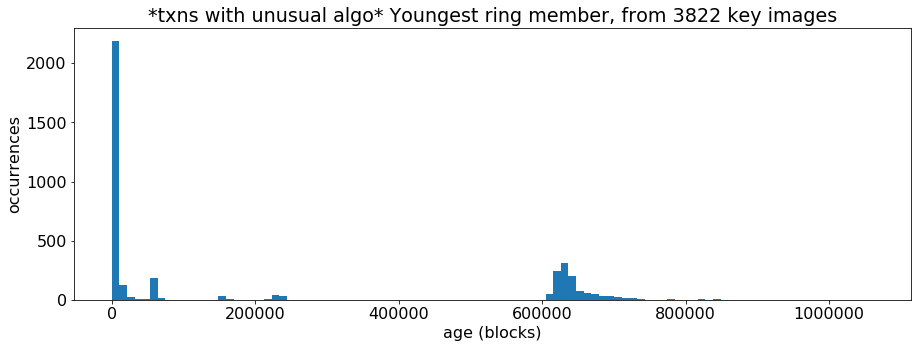

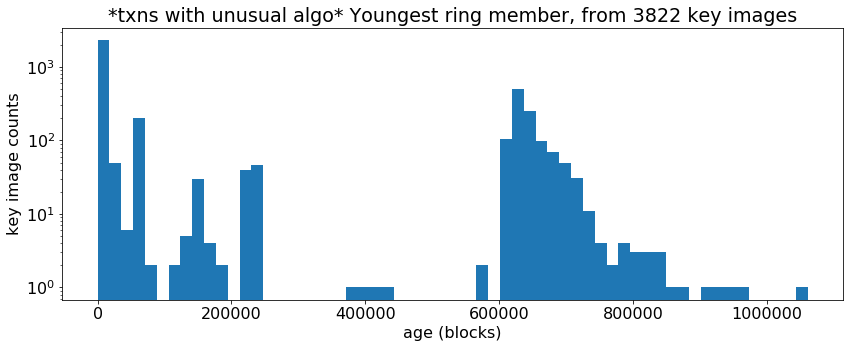

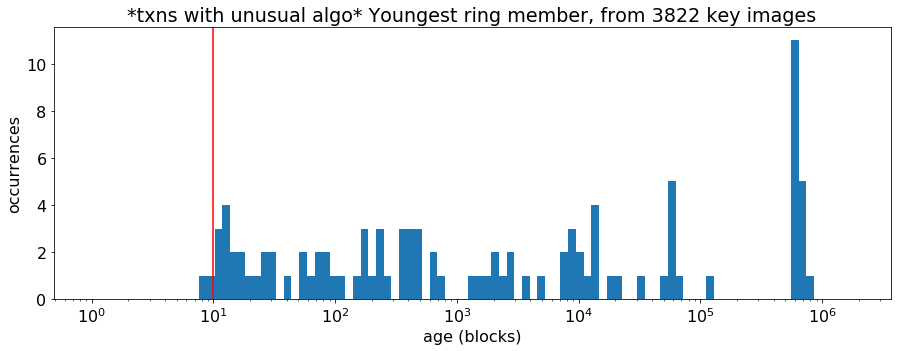

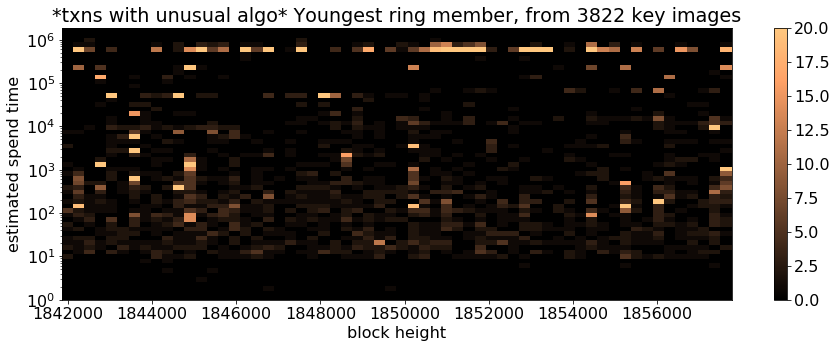

In [37]:
fig = plt.figure(figsize=(15,5), facecolor='white')
uniform_txs = tx_df['youngest'][tx_df['median']>720*30]
strtitle = '*txns with unusual algo* Youngest ring member, from ' + str(len(uniform_txs)) + ' key images'
n, bins, patches = plt.hist(list(uniform_txs), bins = 100)
plt.xlabel('age (blocks)')
plt.ylabel('occurrences')
plt.title(strtitle)
plt.show()

DoubleHistogram(tx_df['youngest'][tx_df['median']>720*30],yscale='log',onlyplot='linear', xlabel='age (blocks)', ylabel = 'key image counts', title = strtitle,figsize=(14,5))

youngest_zoom = 100
fig = plt.figure(figsize=(15,5), facecolor='white')
bins = np.logspace(np.log10(1),np.log10(int(np.max(tx_df['median']))), 100)
n, bins, patches = plt.hist(list(uniform_txs[2]),bins = bins)
plt.xlabel('age (blocks)')
plt.ylabel('occurrences')
plt.title(strtitle)
plt.axvline(10, color='red')
plt.xscale('log')
plt.show()

strtitle = '*txns with unusual algo* Youngest ring member, from ' + str(len(uniform_txs)) + ' key images'
Heatmap(tx_df['block_height'][tx_df['median']>720*30],tx_df['youngest'][tx_df['median']>720*30],vmax=20, yscale='log', xlabel='block height', ylabel = 'estimated spend time', title = strtitle);